In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

In [17]:
from weatherbench2.metrics import MAE, _spatial_average

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
import graphufs

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [6]:
plt.style.use("graphufs.plotstyle")

In [7]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [8]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [9]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [10]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [11]:
truths = ["ERA5", "HRES Analysis"]
models = [
    "GraphUFS",
    "GraphCast",
    "Pangu",
#    "ERA5 Forecasts",
    "IFS ENS Mean",
    "Replay", # bit of a misnomer
]

In [12]:
duration = "240h"
year = 2018

location = "/p1-evaluation/v1/validation"

spatial = {}

for model in models:
    name = model.lower().replace(" ", "_")
    spatial[model] = {}
    middle = duration if model in ("GraphUFS", "Replay") else year
        
    for truth in truths:
        tname = truth.lower().replace(" ", "_")
        spatial[model][truth] = open_dataset(f"{location}/{name}_vs_{tname}_{middle}_deterministic_spatial.nc")

In [14]:
def plot_spatial_metrics(
    mds,
    truth,
    fhr,
    metric="mae",
    fields=("2m_temperature", "surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"),
):

    nrows = len(mds)
    ncols = len(fields)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, 4*nrows), constrained_layout=True, sharex=True, sharey=True)

    for i, (fld, axc) in enumerate(zip(fields, axs.T)):

        vmax = np.nanmax([xds[truth][fld].sel(metric=metric, fhr=fhr).max().values if fld in xds[truth] else np.nan for xds in mds.values()])
        vmin = np.nanmin([xds[truth][fld].sel(metric=metric, fhr=fhr).min().values if fld in xds[truth] else np.nan for xds in mds.values()])

        
        cmap = "viridis"
        if vmax*vmin < 0:
            cmap = "RdBu_r"
            vmax = np.max([vmax, -vmin])
            vmin = -vmax
        else:
            vmin = 0.
        
        for j, (label, xdict) in enumerate(mds.items()):
            ax = axc[j]
            xds = xdict[truth]
            kw = {
                "ax": ax,
                "x": "longitude",
                "vmin": vmin,
                "vmax": vmax,
                "add_colorbar": False,
                "cmap": cmap,
            }
            if fld in xds:
                plotme = xds[fld].sel(metric=metric, fhr=fhr)
                p = plotme.plot(label=label if i == 0 else None, **kw)
    
                fname = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
            else:
                fname = ""
            title = fname
            sps = ax.get_subplotspec()
            ax.set(
                xlabel="",
                ylabel=label,
                title=title,
            ) 
            if not sps.is_first_col():
                ax.set(
                    ylabel="",
                    yticks=[],
                )
            if not sps.is_last_col():
                ax.set(xticks=[])

            if not sps.is_first_row():
                ax.set(title="")
            
            for key in ax.spines.keys():
                ax.spines[key].set_visible(False)

            if sps.is_last_row():
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("bottom", size="5%", pad=0.1)
                ticks = np.linspace(vmin, vmax, 3)
                fig.colorbar(p, cax=cax, ticks=ticks, orientation="horizontal")
            #    fig.colorbar(p, cax=axc, orientation="horizontal")

    
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))
    fig.suptitle(f"{metric.upper()} vs {truth}")
    return fig, axs

/tmp/ipykernel_20171/3723836310.py:74: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  fig.legend(loc="center left", bbox_to_anchor=(1, .5))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


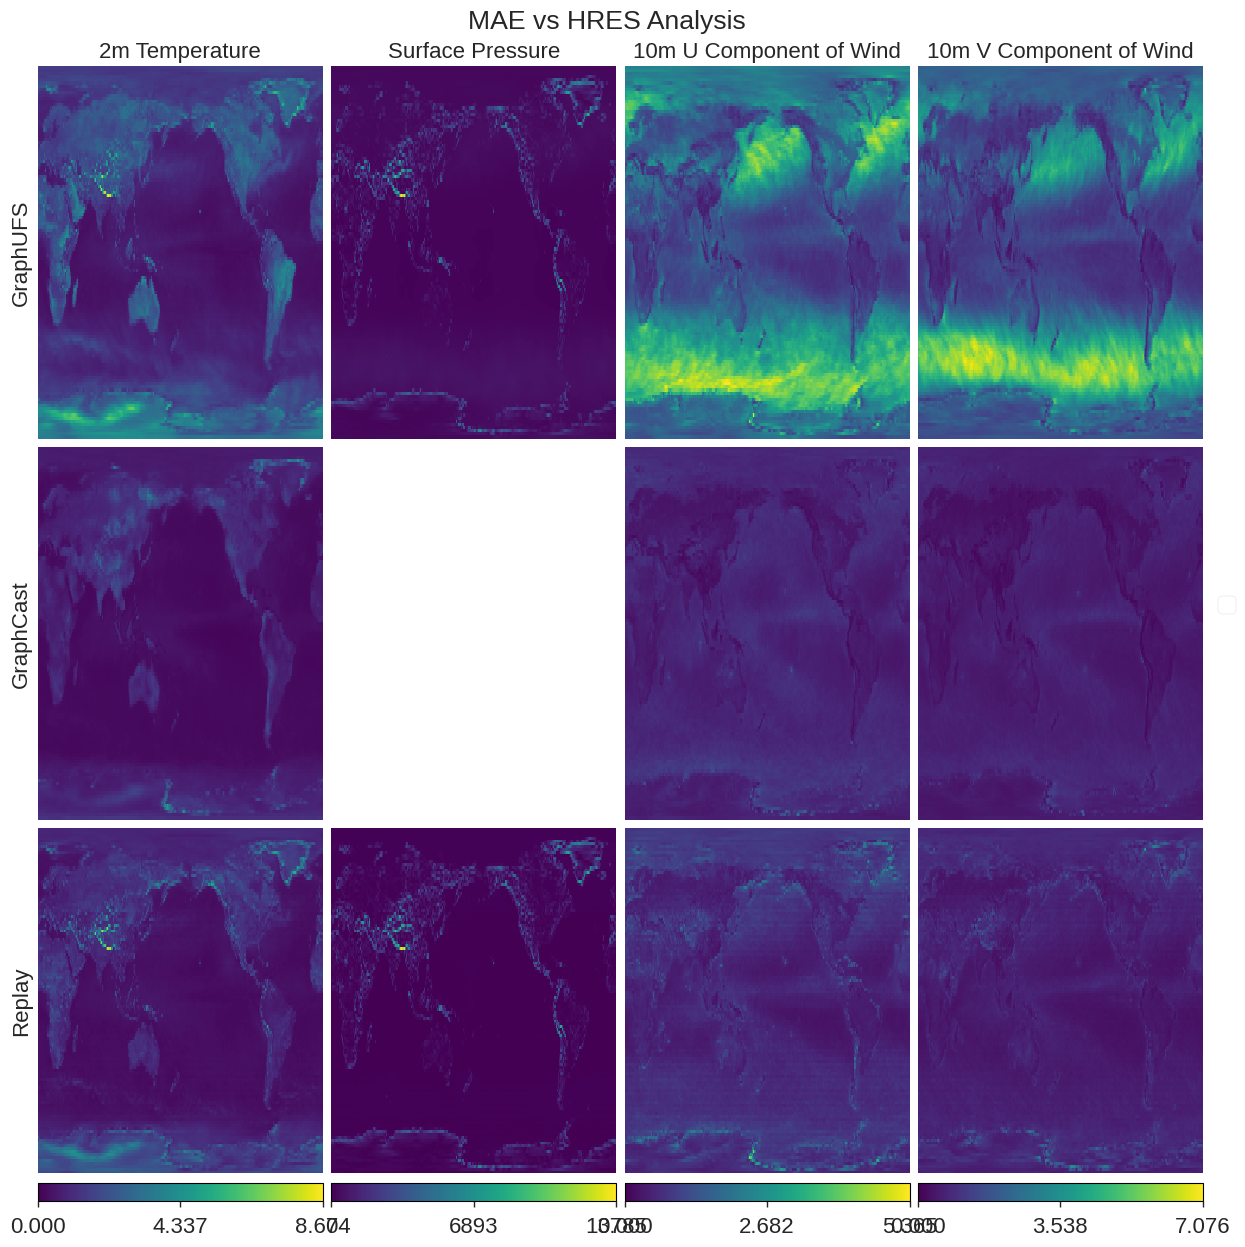

In [15]:
fig, axs = plot_spatial_metrics(
    {k: v for k, v in spatial.items() if k in ["GraphUFS", "GraphCast", "Replay"]},
    truth="HRES Analysis",
    fhr=24,
    metric="mae",
)